In [29]:
# https://leedakyeong.tistory.com/entry/%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5-%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5%EC%9C%BC%EB%A1%9C-%EA%B3%B5%EC%A0%95-%EC%9E%90%EB%8F%99-%EC%A0%9C%EC%96%B4-%EC%8B%9C%EB%AE%AC%EB%A0%88%EC%9D%B4%EC%85%98-%ED%95%B4%EB%B3%B4%EA%B8%B0
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<Axes: xlabel='x', ylabel='y'>

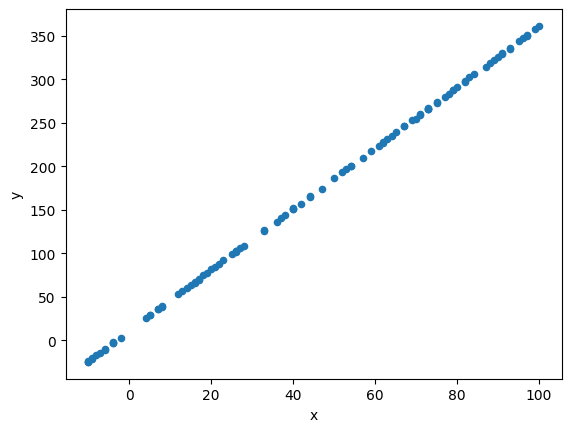

In [30]:
import pandas as pd
import random

temp = [random.randint(-10, 100) for _ in range(100)]
property = [i*3.5 + 10 + random.random()*2 for i in temp]

data = pd.DataFrame({'x':temp, 'y':property})
data.plot(x='x', y='y', kind = 'scatter')

In [31]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(np.array(temp).reshape(-1, 1), np.array(property).reshape(-1, 1))
print(model.coef_)

[[3.50132294]]


In [32]:
class Environment:
    def __init__(self, z, setPoint):
        self.z = z
        self.setPoint = setPoint
        self.terminated = False
        self.state = None

    def reset(self):
        yPred = model.predict(np.array([self.z]).reshape(-1,1)).item()
        self.state = torch.tensor([self.setPoint - yPred])
        return self.state

    def step(self, action):
        if action == 0:
            self.z -= 1
        elif action == 1:
            self.z += 1

        if self.z < -10 or self.z > 100:
            reward = -100. 
            self.terminated = True
            return None, torch.tensor([reward]), self.terminated

        self.state = torch.tensor([self.setPoint - model.predict(np.array([self.z]).reshape(-1, 1)).item()])
        if abs(self.state) <= 5:
            self.terminated = True
        reward = 1/abs(self.state)*5 
        return self.state, reward, self.terminated 

    def render(self):
        return self.z
    

In [33]:
class DQN(nn.Module):
    def __init__(self, outputs):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(1, 16, bias=True)
        self.linear2 = nn.Linear(16, outputs, bias=True)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return torch.unsqueeze(F.log_softmax(x, dim=0), 0)

In [34]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

n_actions = 2
policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [35]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            print('===state',  policy_net(state))
            print(policy_net(state).max(1).indices.view(1,1))
            return policy_net(state).max(1).indices.view(1,1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [36]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

In [37]:
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [38]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(non_final_next_states.size()[0], 1)).squeeze().max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()

    

In [39]:
def Action(x):
    if x.item() == 0:
        return "Down"
    else:
        return "Up"

num_episodes = 100
for i_episode in range(num_episodes):
    epMemory = list()

    z = random.randrange(-10, 100)
    setPoint = random.randrange(math.floor(min(data['y'])), math.ceil(max(data['y'])))
    env = Environment(z=z, setPoint=setPoint)
    state = env.reset()
    print("setPoint", setPoint, "for adjust")

    for t in count():
        action = select_action(torch.tensor([state]).float())
        next_state, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        print(t, "- current x at ", env.render(), 'Action : ', Action(action), 'y : ', next_state, 'reward :', round(reward.item(), 2))

        epMemory.append([state, action, next_state, reward])
        state = next_state
        optimize_model()
        
        if done:
            if env.render() >= -10 and env.render() <= 100:
                _ = [memory.push(epMemory[i][0], epMemory[i][1], epMemory[i][2], epMemory[i][3]) for i in range(len(epMemory))]
                print('Success!!')
            else:
                _ = [memory.push(epMemory[i][0], epMemory[i][1], epMemory[i][2], epMemory[i][3]) for i in range(len(epMemory))]
                print('Fail!!')
            break

        if t >= 10000:
            print('Terminated!!')
            break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print('Complete!!')

setPoint 304 for adjust
0 - current x at  14 Action :  Up y :  tensor([244.0372]) reward : 0.02
1 - current x at  15 Action :  Up y :  tensor([240.5359]) reward : 0.02
===state tensor([[  0.0000, -30.0598]])
tensor([[0]])
2 - current x at  14 Action :  Down y :  tensor([244.0372]) reward : 0.02
3 - current x at  15 Action :  Up y :  tensor([240.5359]) reward : 0.02
4 - current x at  16 Action :  Up y :  tensor([237.0345]) reward : 0.02
===state tensor([[  0.0000, -29.6251]])
tensor([[0]])
5 - current x at  15 Action :  Down y :  tensor([240.5359]) reward : 0.02
6 - current x at  14 Action :  Down y :  tensor([244.0372]) reward : 0.02
7 - current x at  15 Action :  Up y :  tensor([240.5359]) reward : 0.02
8 - current x at  14 Action :  Down y :  tensor([244.0372]) reward : 0.02
9 - current x at  13 Action :  Down y :  tensor([247.5385]) reward : 0.02
10 - current x at  14 Action :  Up y :  tensor([244.0372]) reward : 0.02
11 - current x at  13 Action :  Down y :  tensor([247.5385]) rewa

tensor([[0]])
0 - current x at  9 Action :  Down y :  tensor([7.5438]) reward : 0.66
1 - current x at  10 Action :  Up y :  tensor([4.0425]) reward : 1.24
Success!!
Complete!!
setPoint 334 for adjust
===state tensor([[  0.0000, -17.2670]])
tensor([[0]])
0 - current x at  52 Action :  Down y :  tensor([140.9869]) reward : 0.04
1 - current x at  51 Action :  Down y :  tensor([144.4883]) reward : 0.03
2 - current x at  52 Action :  Up y :  tensor([140.9869]) reward : 0.04
3 - current x at  51 Action :  Down y :  tensor([144.4883]) reward : 0.03
4 - current x at  52 Action :  Up y :  tensor([140.9869]) reward : 0.04
===state tensor([[  0.0000, -17.7017]])
tensor([[0]])
5 - current x at  51 Action :  Down y :  tensor([144.4883]) reward : 0.03
===state tensor([[  0.0000, -18.1363]])
tensor([[0]])
6 - current x at  50 Action :  Down y :  tensor([147.9896]) reward : 0.03
7 - current x at  51 Action :  Up y :  tensor([144.4883]) reward : 0.03
===state tensor([[  0.0000, -18.1363]])
tensor([[0]]

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [ ]:
z = random.randrange(-10, 100)
setPoint = random.randrange(math.floor(min(data['y'])), math.ceil(max(data['y'])))

env = Environment(z=z, setPoint=setPoint)
state = torch.tensor([setPoint - model.predict(np.array([z]).reshape(-1, 1)).item()])

with torch.no_grad():
    print('setPoint', setPoint, 'to adjust')

    for t in count():
        action = select_action(torch.tensor([state]).float())
        next_state, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        print('Current x : ', t, 'at ', env.render(), 'Action :', Action(action), 'setPoint - y : ', next_state, 'reward :', round(reward.item(), 2))

        state = next_state
        if done:
            if env.render() >= -10 and env.render() <= 100:
                print('Success!!')
            else:
                print('Fail!!!')

            break    

setPoint 173 to adjust
===state tensor([[-4.1023, -0.0167]])
tensor([[1]])
Current x :  0 at  73 Action : Up setPoint - y :  tensor([-93.4701]) reward : 0.05
===state tensor([[-4.2758, -0.0140]])
tensor([[1]])
Current x :  1 at  74 Action : Up setPoint - y :  tensor([-96.9679]) reward : 0.05
===state tensor([[-4.4497, -0.0118]])
tensor([[1]])
Current x :  2 at  75 Action : Up setPoint - y :  tensor([-100.4658]) reward : 0.05
===state tensor([[-4.6240, -0.0099]])
tensor([[1]])
Current x :  3 at  76 Action : Up setPoint - y :  tensor([-103.9636]) reward : 0.05
===state tensor([[-4.7986, -0.0083]])
tensor([[1]])
Current x :  4 at  77 Action : Up setPoint - y :  tensor([-107.4614]) reward : 0.05
===state tensor([[-4.9734, -0.0069]])
tensor([[1]])
Current x :  5 at  78 Action : Up setPoint - y :  tensor([-110.9593]) reward : 0.05
===state tensor([[-5.1485, -0.0058]])
tensor([[1]])
Current x :  6 at  79 Action : Up setPoint - y :  tensor([-114.4571]) reward : 0.04
===state tensor([[-5.3237e+